In [1]:
!nvidia-smi

Sat Nov 19 13:21:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    13W /  N/A |     79MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
device = 'cuda:0'

# Read video frames:

In [3]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import torch

In [4]:
ref_video_path = Path('data/ref_video.mp4')
save_frames_path = Path('data/frames')
save_frames_path.mkdir(exist_ok=True, parents=True)

In [5]:
def read_video(file, n_frames=None):
    capture = cv2.VideoCapture(file)
    fps = capture.get(cv2.CAP_PROP_FPS)
    if n_frames is None:
        n_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)

    frames = []

    for _ in tqdm(np.arange(n_frames)):
        success, image_cv = capture.read()

        if not success:
            break

        frame = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame/255, dtype=torch.float32)
        frames.append(frame.permute(2,0,1)[None])

    return frames, fps, n_frames

In [6]:
frames, fps, n_frames = read_video(str(ref_video_path), 500)

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.23it/s]


# Preprocess data

In [7]:
import torchvision.transforms as T

In [8]:
def torch_resize(img, scale_factor):
    width = int(img.shape[3] * scale_factor)
    height = int(img.shape[2] * scale_factor)
    dim = (height, width)
    
    resize_f = T.Resize(dim)

    # resize image
    resized = resize_f(img)
    return resized

In [9]:
scale_factor = 0.5

In [10]:
timgs = []
frames2stitch_freq = 10
for i, frame in enumerate(frames):
    if i % frames2stitch_freq == 0:
        timgs.append(torch_resize(frame, scale_factor).to(device))

In [11]:
len(timgs), timgs[0].shape

(50, torch.Size([1, 3, 360, 640]))

# Stitch by kornia stitcher

In [12]:
from kornia.contrib import ImageStitcher
import kornia.feature as KF
import kornia as K

IS = ImageStitcher(KF.LoFTR(pretrained='outdoor'), estimator='ransac').to(device)

In [13]:
out = timgs[0]
idxs = list(range(1, len(timgs)))
for i in tqdm(idxs):
    try:
        prev_out = out
        out = IS(*[out, timgs[i]])
    except Exception as e:
        print(e)
        out = prev_out

  0%|                                                                                            | 0/49 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:243: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mkpts0_c = torch.stack([i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]], dim=1) * scale0
/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:244: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. 

In [14]:
import matplotlib.pyplot as plt

In [15]:
out.shape

torch.Size([1, 3, 360, 640])

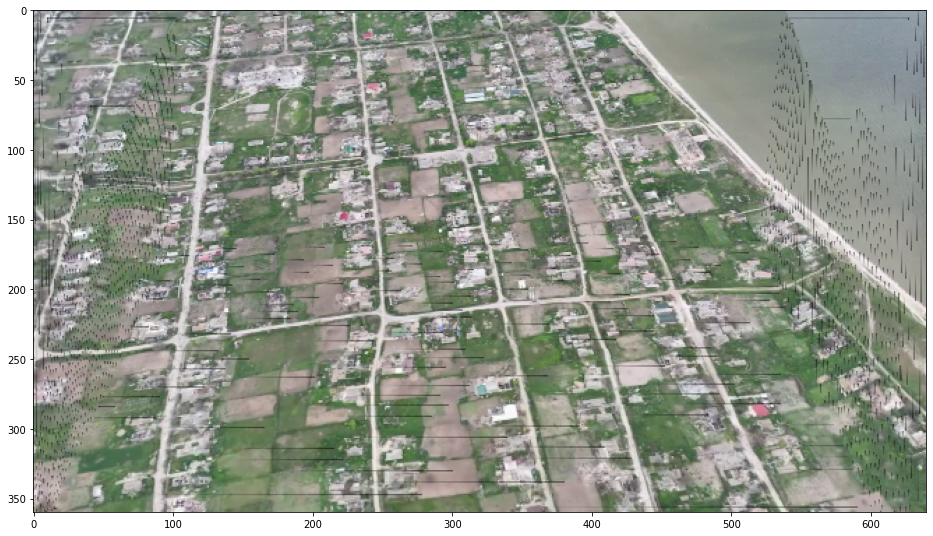

In [16]:
plt.figure(figsize=(16,16))
plt.imshow(out[0].permute(1, 2, 0).cpu())